In [24]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report

In [25]:
# Wczytanie danych
df = pd.read_csv('final_dataset_SMOTE_balanced.csv')

In [26]:
# Konwersja kolumny Date z obsługą błędów oraz sortowanie według daty
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%y', errors='coerce', dayfirst=True)
df = df.dropna(subset=['Date'])  # Usuwamy wiersze z niepoprawnymi datami
df = df.sort_values('Date')

In [27]:
# Przygotowanie danych:
# - FTR to wynik meczu (zmienna docelowa)
# - Usuwamy kolumny, które nie są dostępne przed rozpoczęciem meczu lub mogą powodować problemy:
#   "Unnamed: 0", "FTHG", "FTAG", "MW", "HTFormPtsStr", "ATFormPtsStr", "Date"
df_model = df.drop(columns=['FTHG', 'FTAG', 'MW', 'HTFormPtsStr', 'ATFormPtsStr'])
y = df_model['FTR']
X = df_model.drop(columns=['FTR', 'Date'])

In [28]:
# Podział danych na zbiór treningowy i testowy oparty na czasie (80% najwcześniejszych, 20% najpóźniejszych)
train_size = int(0.8 * len(X))
X_train, X_test = X.iloc[:train_size].copy(), X.iloc[train_size:].copy()
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

In [29]:
# Definicja cech kategorycznych i numerycznych
categorical_features = ['HomeTeam', 'AwayTeam']
numerical_features = [col for col in X_train.columns if col not in categorical_features]

In [30]:
# Konwersja kolumn numerycznych do typu liczbowego (wartości niekonwertowalne stają się NaN)
for col in numerical_features:
    X_train[col] = pd.to_numeric(X_train[col], errors='coerce')
    X_test[col] = pd.to_numeric(X_test[col], errors='coerce')

In [31]:
# Budowa pipeline'u przetwarzania danych:
# Dla cech numerycznych:
#   - imputacja brakujących wartości (SimpleImputer, strategia='median')
#   - standaryzacja (StandardScaler)
# Dla cech kategorycznych: kodowanie OneHotEncoder
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

In [32]:
# Budowa pipeline'u: preprocessing + MLPClassifier
model = Pipeline([
    ('preprocessor', preprocessor),
    ('mlp', MLPClassifier(
        hidden_layer_sizes=(100,),
        activation='relu',
        solver='adam',
        alpha=0.0001,
        learning_rate_init=0.0005,
        early_stopping=True,
        random_state=42,
        max_iter=500
    ))
])


In [33]:
# Trenowanie modelu
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['HTGS', 'ATGS', 'HTGC',
                                                   'ATGC', 'HTP', 'ATP', 'HM1',
                                                   'HM2', 'HM3', 'HM4', 'HM5',
                                                   'AM1', 'AM2', 'AM3', 'AM4',
                                                   'AM5', 'HTFormPts',
                                                   'ATFormPts', 'HTWinStreak3',
                                                   'HTWinStreak5',
                                                   'HTLossStreak3',
                                                   'HTLossStreak5',
                                                   'ATWinStreak3',
                                                   'ATWinStreak5',
                                                   'ATLossStreak3',
                                                   'ATLossStreak5', 'HTGD',
                                                   'ATGD', 'DiffPts',
                                                   'DiffFormPts']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['HomeTeam', 'AwayTeam'])])),
                ('mlp',
                 MLPClassifier(early_stopping=True, learning_rate_init=0.0005,
                               max_iter=500, random_state=42))])

In [34]:
# Predykcja na zbiorze testowym
y_pred = model.predict(X_test)

In [35]:
# Ocena modelu
accuracy = accuracy_score(y_test, y_pred)
print("Dokładność modelu MLP :", accuracy)
print("Raport klasyfikacji:\n", classification_report(y_test, y_pred))


Dokładność modelu MLP : 0.4255111976630964
Raport klasyfikacji:
               precision    recall  f1-score   support

           A       0.46      0.43      0.45       345
           D       0.35      0.31      0.33       341
           H       0.45      0.53      0.49       341

    accuracy                           0.43      1027
   macro avg       0.42      0.43      0.42      1027
weighted avg       0.42      0.43      0.42      1027



,precision,recall,f1-score,support
H,0.46,0.43,0.45,345.00
D,0.35,0.31,0.33,341.00
A,0.45,0.53,0.49,341.00
accuracy,0.43,0.43,0.43,0.43
macro avg,0.42,0.43,0.42,1027.00
weighted avg,0.42,0.43,0.42,1027.00


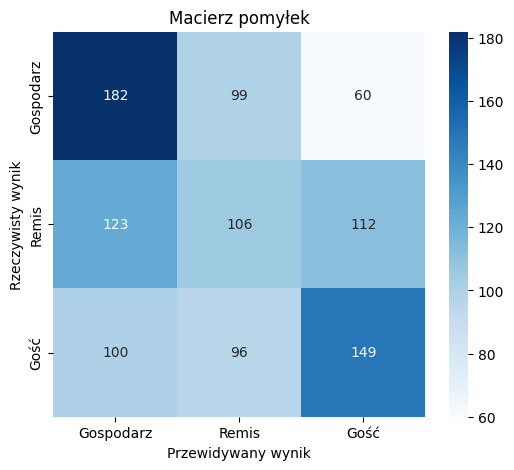

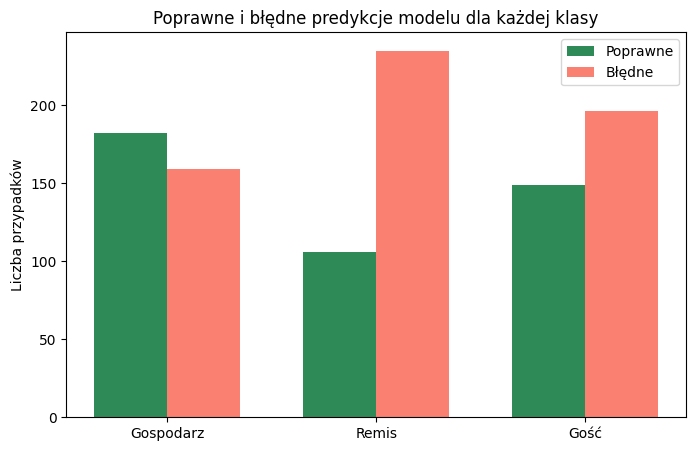

In [36]:
from sklearn.metrics import classification_report
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Zakładamy że masz y_true i y_pred
report = classification_report(y_test, y_pred, target_names=['H', 'D', 'A'], output_dict=True)
df_report = pd.DataFrame(report).transpose()
display(df_report.round(2))
from IPython.display import HTML

styled = df_report.style.background_gradient(cmap="Blues").format("{:.2f}")
HTML(styled.to_html())


from sklearn.metrics import confusion_matrix

# Oblicz macierz pomyłek
cm = confusion_matrix(y_test, y_pred, labels=['H', 'D', 'A'])

# Etykiety klas
labels = ['Gospodarz', 'Remis', 'Gość']

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Przewidywany wynik')
plt.ylabel('Rzeczywisty wynik')
plt.title('Macierz pomyłek')
plt.show()


import numpy as np

# Tworzymy DataFrame z prawdziwymi i przewidzianymi wynikami
results_df = pd.DataFrame({'Rzeczywisty': y_test, 'Predykowany': y_pred})

# Dla każdej klasy policz trafienia i błędy
klasy = ['H', 'D', 'A']
etykiety = ['Gospodarz', 'Remis', 'Gość']
trafienia = []
pomyłki = []

for k in klasy:
    trafienia.append(np.sum((results_df['Rzeczywisty'] == k) & (results_df['Predykowany'] == k)))
    pomyłki.append(np.sum((results_df['Rzeczywisty'] == k) & (results_df['Predykowany'] != k)))

x = np.arange(len(klasy))
width = 0.35

plt.figure(figsize=(8,5))
plt.bar(x - width/2, trafienia, width, label='Poprawne', color='seagreen')
plt.bar(x + width/2, pomyłki, width, label='Błędne', color='salmon')
plt.xticks(x, etykiety)
plt.ylabel('Liczba przypadków')
plt.title('Poprawne i błędne predykcje modelu dla każdej klasy')
plt.legend()
plt.show()

In [37]:
from IPython.display import HTML

styled = df_report.style.background_gradient(cmap="Blues").format("{:.2f}")
HTML(styled.to_html())

,precision,recall,f1-score,support
H,0.46,0.43,0.45,345.00
D,0.35,0.31,0.33,341.00
A,0.45,0.53,0.49,341.00
accuracy,0.43,0.43,0.43,0.43
macro avg,0.42,0.43,0.42,1027.00
weighted avg,0.42,0.43,0.42,1027.00


In [38]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
import numpy as np

# 1. USUWANIE niepotrzebnych cech tekstowych z historii meczów
#columns_to_drop = ['HM1', 'HM2', 'HM3', 'HM4', 'HM5', 'AM1', 'AM2', 'AM3', 'AM4', 'AM5']
#X_train = X_train.drop(columns=columns_to_drop, errors="ignore")
X_test = X_test.drop(columns=columns_to_drop, errors="ignore")

# 2. Przywrócenie LabelEncoder (jeśli go już nie ma)
label_encoder = LabelEncoder()
label_encoder.fit(['D', 'H', 'NH'])  # zakładamy, że używasz tylko tych 3 klas

# 3. Lista kolumn
categorical_features = ['HomeTeam', 'AwayTeam']
numerical_features = [col for col in X_train.columns if col not in categorical_features]

# 4. Preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), numerical_features),
        
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

# 5. Pipeline + MLP
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('mlp', MLPClassifier(random_state=42, max_iter=500))
])

# 6. Parametry
param_grid = {
    "mlp__hidden_layer_sizes": [(50,), (100,), (150,), (100, 50), (150, 75), (100, 100)],
    "mlp__activation": ["relu", "tanh"],
    "mlp__solver": ["adam", "lbfgs"],
    "mlp__alpha": [0.0001, 0.001, 0.01],
    "mlp__learning_rate_init": [0.0005, 0.001, 0.005],
    "mlp__early_stopping": [True]
}

# 7. GridSearchCV
grid_search = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    verbose=2,
    n_jobs=-1
)

# 8. Trening
grid_search.fit(X_train, y_train)

# 9. Wyniki
print("✅ Najlepsze parametry:", grid_search.best_params_)
print("✅ Najlepsza dokładność (walidacja):", grid_search.best_score_)

best_model = grid_search.best_estimator_
test_accuracy = best_model.score(X_test, y_test)
print("✅ Dokładność na zbiorze testowym:", test_accuracy)

# 10. Raport klasyfikacji
y_pred = best_model.predict(X_test)
print("\n📊 Raport klasyfikacji:\n")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))


NameError: name 'columns_to_drop' is not defined